In [2]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import pandas as pd
from torchvision.utils import save_image, make_grid
import openpyxl
import json
import cv2
import warnings
from torch.utils.data import DataLoader

pd.set_option('display.max.colwidth', 50)
pd.set_option('display.width', 1000)
warnings.filterwarnings(action='ignore')

In [3]:
# Hyper parameters

# DEVICE = torch.device("cpu") # for CPU only
# DEVICE = torch.device("cuda") # for GPU
DEVICE = torch.device("mps:0") # for M1 Mac

batch_size = 1
x_dim  = 200
hidden_dim = 400
latent_dim = 200
lr = 1e-3
epochs = 10000

# source rescale
rescale_width= 200
rescale_height = 200

In [4]:
# Image preparation
path = "../../data/iae/sdd/"

raw_dataset = pd.read_excel('../../data/iae/sdd/meta.xlsx', header=0, index_col=False)
print("Original Raw Data shape : ", raw_dataset.shape)

normal_dataset = raw_dataset.loc[raw_dataset["defect"]==0]
print("> Normal data shape : ", normal_dataset.shape)

abnormal_dataset = raw_dataset.loc[raw_dataset["defect"]==1]
print("> Abnormal data shape : ", abnormal_dataset.shape)

# extract ROI from label file
normal_roi = {}
abnormal_roi = {}

for name in normal_dataset["name"]:
    with open(path+name+".json") as jsonfile:
        meta = json.load(jsonfile)
        for m in meta["shapes"]:
            if m["label"]=='ROI':
                normal_roi[name] = m["points"]

for name in abnormal_dataset["name"]:
    with open(path+name+".json") as jsonfile:
        meta = json.load(jsonfile)
        for m in meta["shapes"]:
            if m["label"]=='ROI':
                abnormal_roi[name] = m["points"]


print("Loaded Normal Label file : ", len(normal_roi))
print("Loaded Abnormal Label file : ", len(abnormal_roi))

# image normalization with perspective transformation
for name in normal_roi:
    src = cv2.imread(path+name+".png")
    roi_pts = np.array(normal_roi[name],dtype=np.float32)
    dst_pts = np.float32([[0, 0],[0, rescale_height - 1],[rescale_width - 1, rescale_height - 1],[rescale_width - 1, 0]])
    trans = cv2.getPerspectiveTransform(roi_pts, dst_pts)
    src_croped = cv2.warpPerspective(src,trans,(rescale_width, rescale_height),flags=cv2.INTER_LINEAR)
    src_croped = cv2.cvtColor(src_croped, cv2.COLOR_BGR2GRAY)
    src_croped = cv2.equalizeHist(src_croped)
    cv2.imwrite(path+name+"_crop.png", src_croped)

for name in abnormal_roi:
    src = cv2.imread(path+name+".png")
    roi_pts = np.array(abnormal_roi[name],dtype=np.float32)
    dst_pts = np.float32([[0, 0],[0, rescale_height - 1],[rescale_width - 1, rescale_height - 1],[rescale_width - 1, 0]])
    trans = cv2.getPerspectiveTransform(roi_pts, dst_pts)
    src_croped = cv2.warpPerspective(src,trans,(rescale_width, rescale_height),flags=cv2.INTER_LINEAR)
    src_croped = cv2.cvtColor(src_croped, cv2.COLOR_BGR2GRAY)
    src_croped = cv2.equalizeHist(src_croped)
    cv2.imwrite(path+name+"_crop.png", src_croped)


Original Raw Data shape :  (44, 2)
> Normal data shape :  (14, 2)
> Abnormal data shape :  (30, 2)
Loaded Normal Label file :  14
Loaded Abnormal Label file :  30


In [5]:
# Custom Dataset to use in torch
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class SDDImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, train=True):
        # self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        raw = pd.read_excel(img_dir+annotations_file, header=0, index_col=False, names=['filename', 'label'])
        if train==True:
            self.img_labels = raw.loc[raw["label"]==0] # normal image
        else:
            self.img_labels = raw.loc[raw["label"]==1] # defect image
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


from torch.utils.data import DataLoader
import torchvision.transforms as transforms

sdd_transform = transforms.Compose([
        transforms.ToPILImage(),
        #transforms.Resize((200,200)),
        transforms.ToTensor(),
])

kwargs = {'num_workers': 0, 'pin_memory': True} 

train_dataset = SDDImageDataset("annotation.xlsx", path, transform=sdd_transform, train=True)
test_dataset  = SDDImageDataset("annotation.xlsx", path, transform=sdd_transform, train=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)


In [6]:
# Define model class

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       # (i.e., parateters of simple tractable normal distribution "q"
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        return x_hat, mean, log_var

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [7]:
# Define Loss function and optimizer
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [8]:
# train variational auto encoder model
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        #print(batch_idx, x.size())
        #x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  29630.58112980769
	Epoch 2 complete! 	Average Loss:  29393.20597956731
	Epoch 3 complete! 	Average Loss:  29321.188701923078
	Epoch 4 complete! 	Average Loss:  29201.664813701922
	Epoch 5 complete! 	Average Loss:  29183.333533653848
	Epoch 6 complete! 	Average Loss:  29159.1484375
	Epoch 7 complete! 	Average Loss:  29164.619891826922
	Epoch 8 complete! 	Average Loss:  29196.219501201922
	Epoch 9 complete! 	Average Loss:  29289.703575721152
	Epoch 10 complete! 	Average Loss:  29208.046424278848
	Epoch 11 complete! 	Average Loss:  29171.635516826922
	Epoch 12 complete! 	Average Loss:  29136.740084134617
	Epoch 13 complete! 	Average Loss:  29105.13641826923
	Epoch 14 complete! 	Average Loss:  28784.798076923078
	Epoch 15 complete! 	Average Loss:  28573.80018028846
	Epoch 16 complete! 	Average Loss:  28253.95763221154
	Epoch 17 complete! 	Average Loss:  28082.820162259617
	Epoch 18 complete! 	Average Loss:  28140.84465144231
	Epoch 1

KeyboardInterrupt: 

In [124]:
import matplotlib.pyplot as plt
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        #x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

  0%|          | 0/30 [00:00<?, ?it/s]


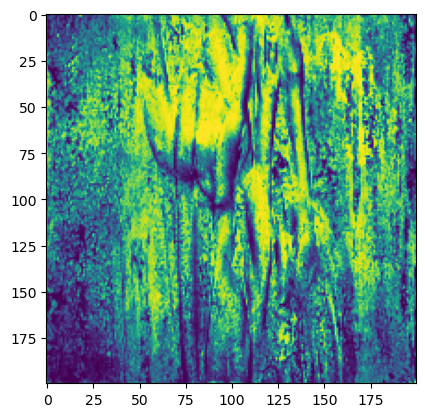

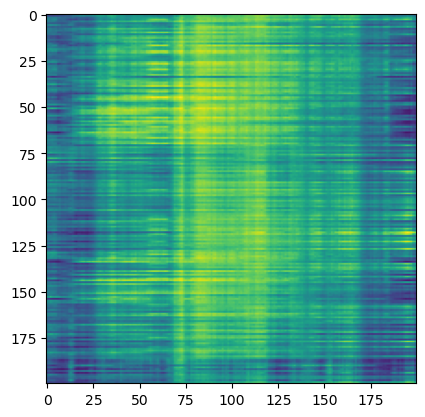

In [127]:
def show_image(x, idx):
    x = x.view(batch_size, 200, 200)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())
show_image(x, idx=0)
show_image(x_hat, idx=0)